# Global harvested areas

In [4]:
# load packages
import numpy as np
import pandas as pd
import xarray as xr

In [5]:
#######################
#paths required for opening harvested area data
#######################

#location of MIRCA data
MIRCA_loc = './'
#path to updated harvested area dataset
ha_path = './harvested_areas_2000-2021.nc'

#######################
#paths required for creating updated harvested area data
#######################

#location of FAO data
FAO_loc = './Production_Crops_Livestock_E_All_Data_NOFLAG.csv'
#where to put output
output_loc = './'
#associate grid points with specific countries
country_grid_loc = './global_country_grid.txt'
#location of country code converter file
country_code_loc = './FAO_country_codes.csv'

In [6]:
crop_dict = {
    'maize' : {
        'MIRCA_no' : '02',
        'FAO_name' : 'Maize (corn)'
    },
    'wheat' : {
        'MIRCA_no' : '01',
        'FAO_name' : 'Wheat'
    }
}

In [7]:
# print options for DataFrames
pd.set_option('display.max_rows', 350)

## Update MIRCA2000 harvested areas using FAO data

MIRCA2000 gives grid-cell-based rain-fed and irrigated harvested areas for approximately the year 2000.
The FAO gives country-specific harvested areas on a yearly basis.
Here I scale the MIRCA2000 data using the FAO data to get a yearly, grid-cell based rain-fed and irrigated harvested area dataset.
Scaling is done on a per-country basis.

Weaknesses:
1. The ratio of rain-fed to irrigated harvested area remains fixed at the year 2000 values
2. Within countries the ratio of harvested areas remains fixed between grid cells at the value from the year 2000 (in reality it is unlikely that there is a uniform scaling of harvested area across a country).


In [19]:
#import dataframe linking grid cells to countries
country_grid_df = pd.read_csv(country_grid_loc, sep=' ')
country_grid_df

lon    lat Area Code  number
0      -179.75  89.75       NaN     NaN
1      -179.25  89.75       NaN     NaN
2      -178.75  89.75       NaN     NaN
3      -178.25  89.75       NaN     NaN
4      -177.75  89.75       NaN     NaN
...        ...    ...       ...     ...
259195  177.75 -89.75       ATA   160.0
259196  178.25 -89.75       ATA   160.0
259197  178.75 -89.75       ATA   160.0
259198  179.25 -89.75       ATA   160.0
259199  179.75 -89.75       ATA   160.0

[259200 rows x 4 columns]

In [20]:
#import MIRCA2000 data and organise it
def mirca_df_organiser(df,water_source):
    df.columns = lon
    df.index = lat
    
    df = df.melt(var_name='lon',value_name='mirca_' + water_source)
    df.insert(loc=1, column='lat', value=list(lat)*lon.size)
    df.sort_values(['lat', 'lon'], ascending=[False, True], inplace=True)
    df.reset_index(drop=True,inplace=True)
    
    return df

def mirca_open(crop):
   #import MIRCA2000 data and convert to dataArray
    crop_map_rf = pd.read_csv(MIRCA_loc + f'annual_area_harvested_rfc_crop{crop_dict[crop]["MIRCA_no"]}_ha_30mn.asc.gz',skiprows=6,sep=' ',header=None).drop([720], axis=1)
    crop_map_rf = mirca_df_organiser(crop_map_rf,'rf')
    
    crop_map_ir = pd.read_csv(MIRCA_loc + f'annual_area_harvested_irc_crop{crop_dict[crop]["MIRCA_no"]}_ha_30mn.asc.gz',skiprows=6,sep=' ',header=None).drop([720], axis=1)
    crop_map_ir = mirca_df_organiser(crop_map_ir,'ir')
    
    mirca_ha = crop_map_rf.merge(crop_map_ir)
    
    mirca_ha_df = mirca_ha.merge(country_grid_df[['lon','lat','Area Code']],on=['lon','lat'])
    
    return mirca_ha_df
#mirca_open('maize')

In [21]:
#import file useful for converting between different areas codes used to identify countries
country_codes_df = pd.read_csv(country_code_loc)
country_codes_df.loc[country_codes_df['Country'] == 'China, mainland','ISO3 Code'] = 'CHN'
country_codes_df = country_codes_df[country_codes_df['Country'] != 'China']
country_codes_df

FileNotFoundError: [Errno 2] No such file or directory: './FAO_country_codes.csv'

In [22]:
#import FAO data
def FAO_df_creator(crop,year):

    #import FAO data, select year of interest and reorganise
    FAO_df = pd.read_csv(FAO_loc,encoding='latin1')
    FAO_df = FAO_df.loc[(FAO_df['Element']=='Area harvested') & (FAO_df['Item']==crop_dict[crop]['FAO_name'])][['Area Code (M49)','Area',f'Y{year}']]
    FAO_df['Area Code (M49)'] = FAO_df['Area Code (M49)'].str[1:4].astype(int)
    FAO_df.rename(columns={f'Y{year}': 'FAO_harvested_area'},inplace=True)
    FAO_df = FAO_df[FAO_df['Area'] != 'China'] #remove china to avoid double counting


    #Combine Sudan
    Sudan_area = FAO_df.loc[FAO_df['Area Code (M49)'].isin([728,729,736])]['FAO_harvested_area'].sum()
    FAO_df = FAO_df[FAO_df['Area Code (M49)'] != 728] #South Sudan (2012-)
    FAO_df = FAO_df[FAO_df['Area Code (M49)'] != 736] # Sudan (former) (-2011)
    FAO_df.loc[FAO_df['Area Code (M49)'] == 729,'FAO_harvested_area'] = Sudan_area 


    iso3_codes = []
    for index, row in FAO_df.iterrows():
        area_code_M49 = row['Area Code (M49)']
        #print(area_code_M49)
        iso3_codes.append(country_codes_df.loc[country_codes_df['M49 Code'] == area_code_M49]['ISO3 Code'].values[0])
        #print(country_codes_df.loc[country_codes_df['M49 Code'] == area_code_M49]['ISO3 Code'].values[0])
    #print(iso3_codes)
    FAO_df['Area Code'] = np.array(iso3_codes)
    #FAO_df.loc[FAO_df['Area']=='China, mainland','Area Code'] = 'CHN'

    return FAO_df
#FAO_df_creator('maize',2021)

In [23]:
#scale Mirca2000 data using FAO data
def mirca_scaler(crop,year):
    mirca_ha_df = mirca_open(crop)
    FAO_df = FAO_df_creator(crop,year)
    
    country_df = mirca_ha_df.groupby('Area Code').sum().reset_index()
    country_df['mirca_tot'] = country_df['mirca_rf'] + country_df['mirca_ir']
    country_df = country_df.merge(FAO_df, how='inner', on='Area Code').drop(columns=['lon','lat','Area'])
    country_df['ratio'] = country_df['FAO_harvested_area']/country_df['mirca_tot']
    country_df = country_df.replace([np.inf, -np.inf], 0)

    print(f'FAO harvested area of {crop} in {year} = %.2f Mha' % (country_df['FAO_harvested_area'].sum()*10**-6) )
    print(f'MIRCA2000 harvested area of {crop} = %.2f Mha' % (country_df['mirca_tot'].sum()*10**-6) )
    country_df.sort_values('ratio')
    
    #multiply harvested area of individual grid cells by appropriate ratio
    mirca_ha_df['new_rf'] = mirca_ha_df['mirca_rf']
    mirca_ha_df['new_ir'] = mirca_ha_df['mirca_ir']

    for iso in country_df['Area Code']:
        ratio = country_df.loc[country_df['Area Code'] == iso, "ratio"]
        mirca_ha_df.loc[mirca_ha_df['Area Code'] == iso, "new_rf"] *= ratio.values[0]
        mirca_ha_df.loc[mirca_ha_df['Area Code'] == iso, "new_ir"] *= ratio.values[0]
    print(f'rainfed harvested area of {crop} in year {year} = %.2f Mha' % (mirca_ha_df['new_rf'].sum()*10**-6) )
    print(f'irrigated harvested area {crop} in year {year} = %.2f Mha' % (mirca_ha_df['new_ir'].sum()*10**-6) )
    print(f'total harvested area {crop} in year {year} = %.2f Mha' % ((mirca_ha_df['new_rf'] + mirca_ha_df['new_ir']).sum()*10**-6) )


    return mirca_ha_df
df = mirca_scaler('maize',2020)

FileNotFoundError: [Errno 2] No such file or directory: './Production_Crops_Livestock_E_All_Data_NOFLAG.csv'

In [135]:
#create dataset for multiple years and crops
start_year = 2000
end_year = 2021
yearlist = np.arange(start_year,end_year+1)

crop_ds_list = []
for crop in crop_dict.keys():
    ha_rf_dA_list = []
    ha_ir_dA_list = []
    for year in yearlist:
        ha_df = mirca_scaler(crop,year)
        ha_rf_dA_list.append(ha_df[['lat','lon','new_rf']].set_index(["lat", "lon"]).to_xarray().rename({'new_rf' : f'harvested_area_rf_{crop}'}))
        ha_ir_dA_list.append(ha_df[['lat','lon','new_ir']].set_index(["lat", "lon"]).to_xarray().rename({'new_ir' : f'harvested_area_ir_{crop}'}))
    crop_ds_list.append( xr.concat(ha_rf_dA_list, dim='year').assign_coords(year=yearlist) )
    crop_ds_list.append( xr.concat(ha_ir_dA_list, dim='year').assign_coords(year=yearlist) )
    
crop_ds_list
crop_ds = xr.merge(crop_ds_list)
crop_ds

FAO harvested area of maize in 2000 = 135.68 Mha
MIRCA2000 harvested area of maize = 150.83 Mha
rainfed harvested area of maize in year 2000 = 110.14 Mha
irrigated harvested area maize in year 2000 = 26.23 Mha
total harvested area maize in year 2000 = 136.37 Mha
FAO harvested area of maize in 2001 = 136.12 Mha
MIRCA2000 harvested area of maize = 150.83 Mha
rainfed harvested area of maize in year 2001 = 109.92 Mha
irrigated harvested area maize in year 2001 = 26.89 Mha
total harvested area maize in year 2001 = 136.81 Mha
FAO harvested area of maize in 2002 = 136.22 Mha
MIRCA2000 harvested area of maize = 150.83 Mha
rainfed harvested area of maize in year 2002 = 110.00 Mha
irrigated harvested area maize in year 2002 = 26.91 Mha
total harvested area maize in year 2002 = 136.91 Mha
FAO harvested area of maize in 2003 = 143.36 Mha
MIRCA2000 harvested area of maize = 150.83 Mha
rainfed harvested area of maize in year 2003 = 116.62 Mha
irrigated harvested area maize in year 2003 = 27.42 Mha
t

<xarray.Dataset>
Dimensions:                  (lat: 360, lon: 720, year: 22)
Coordinates:
  * lat                      (lat) float64 -89.75 -89.25 -88.75 ... 89.25 89.75
  * lon                      (lon) float64 -179.8 -179.2 -178.8 ... 179.2 179.8
  * year                     (year) int64 2000 2001 2002 2003 ... 2019 2020 2021
Data variables:
    harvested_area_rf_maize  (year, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0
    harvested_area_ir_maize  (year, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0
    harvested_area_rf_wheat  (year, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0
    harvested_area_ir_wheat  (year, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0

In [136]:
#export to file - remove #'s if you want to export
#comp = dict(zlib=True, complevel=9)
#encoding = {var: comp for var in crop_ds.data_vars}

#crop_ds.to_netcdf(output_loc + f'harvested_areas_{start_year}-{end_year}.nc',encoding=encoding)

## Open harvested area data

In [8]:
#MIRCA2000 data

#global longitude and latitude coordinates for 0.5° grid
lon = np.linspace(-179.75,179.75,720)
lat = np.linspace(89.75,-89.75,360)

#function to create a crop mask (crop present/absent in a grid cell)
def create_crop_mask(rf_dA,ir_dA,min_area):
    rf_dA = rf_dA.where(rf_dA > min_area, 0)
    rf_dA = rf_dA.where(rf_dA < min_area, 1)
    
    ir_dA = ir_dA.where(ir_dA > min_area, 0)
    ir_dA = ir_dA.where(ir_dA < min_area, 1)
    
    crop_mask_dict = {'rf' : rf_dA.load(), 'ir' : ir_dA.load()}
    
    return crop_mask_dict

#open MIRCA 2000 harvested area data as dataArray
def mirca_open(crop):
    
    #minimum harvested area to consider
    min_area = 500 #hectares
    

    #import MIRCA2000 data and convert to dataArray
    crop_map_rf = pd.read_csv(MIRCA_loc + f'annual_area_harvested_rfc_crop{crop_dict[crop]["MIRCA_no"]}_ha_30mn.asc.gz',skiprows=6,sep=' ',header=None).drop([720], axis=1)
    crop_map_ir = pd.read_csv(MIRCA_loc + f'annual_area_harvested_irc_crop{crop_dict[crop]["MIRCA_no"]}_ha_30mn.asc.gz',skiprows=6,sep=' ',header=None).drop([720], axis=1)

    #convert to dataArray
    crop_map_rf_dA = xr.DataArray(crop_map_rf, coords=[lat, lon], dims=['lat','lon'])
    crop_map_ir_dA = xr.DataArray(crop_map_ir, coords=[lat, lon], dims=['lat','lon']) 
    
    #mask for whether or not a grid cell has more than the minimum harvested area
    crop_mask_dict = create_crop_mask(crop_map_rf_dA,crop_map_ir_dA,min_area)
    
    #harvested areas
    crop_map_rf_dA = crop_map_rf_dA * crop_mask_dict['rf']
    crop_map_ir_dA = crop_map_ir_dA * crop_mask_dict['ir']
    
    crop_map_dict = {'rf' : crop_map_rf_dA.load(), 'ir' : crop_map_ir_dA.load()}
    
    return crop_map_dict, crop_mask_dict

In [9]:
#Updated MIRCA2000 data

ha_ds = xr.open_dataset(ha_path)

#check harvested areas make sense
year = 2001
for key in ha_ds.keys():
    print(key,'= %.2f Mha' % (ha_ds[key].sel(year=year).sum() * 10**-6) )
    
ha_ds

/bg/home/martin-l/.local/lib/python3.9/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.0.3) or chardet (None)/charset_normalizer (3.0.1) doesn't match a supported version!
  warnings.warn(


harvested_area_rf_maize = 109.92 Mha
harvested_area_ir_maize = 26.89 Mha
harvested_area_rf_wheat = 152.22 Mha
harvested_area_ir_wheat = 61.83 Mha


<xarray.Dataset>
Dimensions:                  (lat: 360, lon: 720, year: 22)
Coordinates:
  * lat                      (lat) float64 -89.75 -89.25 -88.75 ... 89.25 89.75
  * lon                      (lon) float64 -179.8 -179.2 -178.8 ... 179.2 179.8
  * year                     (year) int64 2000 2001 2002 2003 ... 2019 2020 2021
Data variables:
    harvested_area_rf_maize  (year, lat, lon) float64 ...
    harvested_area_ir_maize  (year, lat, lon) float64 ...
    harvested_area_rf_wheat  (year, lat, lon) float64 ...
    harvested_area_ir_wheat  (year, lat, lon) float64 ...

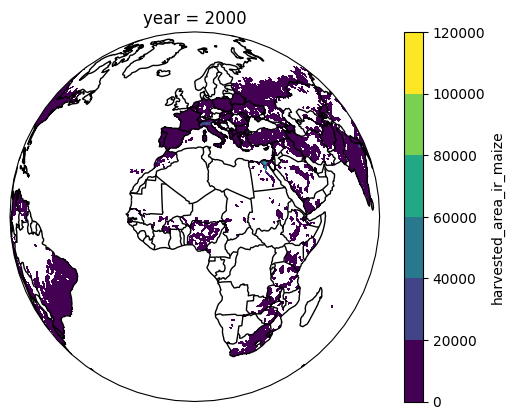

In [15]:
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
data = ha_ds.harvested_area_ir_maize.where(ha_ds.harvested_area_ir_maize > 0).sel(year=2000)
ax = plt.axes(projection=ccrs.Orthographic(5,15))
data.plot.contourf(transform=ccrs.PlateCarree())
ax.coastlines();
ax.add_feature(cartopy.feature.BORDERS)